<h3><center>ELCE 455 Machine Learning with Python</center></h3>
<h3><center>Final Project</center></h3>

<h1><center>Fundamental Research Track</center></h1>
<h1><center>Convolutional encoder-decoder networks</center></h1>

<h3><center>Dair Ungarbayev</center></h3>

### Abstract

This project is focused on convolutional encoder-decoder networks. The main principles behind such models are discussed. Next, the encoder-decoder network is implemented using Keras and trained on the Fashion-MNIST dataset. The trained encoder and decoder are subsequently applied to the tasks of transfer learning for classification and image generation respectively. The trained encoder-decoder network is shown to successfully reconstruct its inputs. The encoder is applied to the task of classification to obtain a test accuracy of 89%. The image generation task using a decoder is demonstrated qualitatively.

### Introduction

The encoder-decoder networks consist of an encoder, which maps the input data into a code representation [1], also called latent code, and a decoder, which constructs a desired output from the produced code.

One example of the encoder-decoder networks is an autoencoder model, which learns to reconstruct its input. However, it is not a strict requirement that the output should match the input. In other words, the domain of the input data and the output data need not be the same.

Moreover, the specific structure of the underlying encoder and decoder models is not set in stone as one could choose to use recurrent neural networks [2], convolutional neural networks [1] or multilayer perceptrons as bases of the models.

Thus, as the area of encoder-decoder models is very broad, the scope of this project is limited to convolutional encoder-decoder networks where the domain of the input and output is the same.

A generic structure of an encoder-decoder can be seen in Fig. 1. 

<img align="top" src="figs/generic.jpg" alt="drawing" width="500"/><br>
<center>Fig. 1: The generic block diagram representation of an encoder-decoder model.</center>

### Working principles

##### Convolution

The convolution operation is defined as:

\begin{align}
s[n] = (x \ast w) [n] = \sum_{a=-\infty}^{\infty} x[a]w[n-a], \quad (1)
\end{align}

where $x$ and $w$ are discrete time functions [3].

In this project, as well as in the context of convolutional neural networks in general, since the input data has more than one dimension, the equation can be extended as:

\begin{align}
s[i,j] = (x \ast w) [i,j] = \sum_m \sum_n x[m,n]w[i-m,j-n],
\end{align}

As in the case of simple edge detection, the convolution operation can filter the data to highlight specific feature from which the model learns.

According to [3], there are 3 main advantages of using convolutions as opposed to the fully-connected multi layer perceptrons:

1. Sparse interactions
2. Parameter sharing
3. Equivariance

When using convolutions, a particular output of a layer is not affected by all of the input to the layer. This is what sparse interactions mean. On the other hand, matrix multiplication involved in multilayer perceptrons results in an output neuron in a layer is being affected by (connected to) all of the input neurons to that layer. 

Sparse interactions are achieved by using kernels smaller than the input. Consider that the larger the kernel, the greater the area that it covers when filtering through (being convolved with) the input. Thus each point in the output is affected by the larger subset of the input. On the other hand, smaller kernels mean that less of the input is used to get a particular output point. The main advantage of sparse interactions is in terms of savings in computational cost.

Parameter sharing means that the learned parameters are not "locked in" to a specific input point, which is the case in multilayer perceptrons. In other words, the learned convolutional kernel slides through the whole input. The benefit of parameter sharing in mainly due to reduced memory requirement as less parameters are used. This can be easily seen in practice when using ```model.summary()``` function in Keras. When designing a typical convolutional neural network with ```Dense``` layers at the output side, the number of trainable parameters is very large in ```Dense``` layers compared to convolutional layers.

Equivariance property means that when an input to a layer changes, the output is changed in the same way. For example, if an object in an image is translated, meaning it shifts its position, the output will reflect that translation. This is also related to the important property of convolutional neural networks - translation invariance.

##### Transposed convolution

In the case of a decoder, one may wonder how the dimensionality of the input to the decoder is increased at the output side. One way is to simply upsample the input by interpolation and then to perform regular convolution on it for learning purposes. It is important to note that the inputs to the convolutions would have to be padded in order to preserve the dimensionality.

Another way to upsample the input is to use transposed convolutions [4]. The main idea of transposed convolutions is to represent the convolution (Eq.1) as a matrix multiplication. In other words, how to use matrix multiplication to obtain the same output as in the case of convolution?

The matrix multiplication equivalent of a convolution is as follows:

\begin{align}
\textbf{s}=\textbf{W} \textbf{x},
\end{align}

where the $\textbf{s}$ is the flattened vector version of $s$, $\textbf{W}$ is the sparse matrix representation of $w$ and $\textbf{x}$ is the flattened vector version of $x$.

For example, the particular spare matrix representation of a 3x3 kernel that is applied to a 4x4 input would be as follows [4]:

\begin{bmatrix}
w_{0,0}&w_{0,1}&w_{0,2} &0& w_{1,0}&w_{1,1}&w_{1,2} &0& w_{2,0}&w_{2,1}&w_{2,2}&0&0&0&0&0\\
0&w_{0,0}&w_{0,1}&w_{0,2}&0&w_{1,0}&w_{1,1}&w_{1,2}&0&w_{2,0}&w_{2,1}&w_{2,2}&0&0&0&0\\
0&0&w_{0,0}&w_{0,1}&w_{0,2}&0&w_{1,0}&w_{1,1}&w_{1,2}&0&w_{2,0}&w_{2,1}&w_{2,2}&0&0&0&\\
0&0&0&w_{0,0}&w_{0,1}&w_{0,2}&0&w_{1,0}&w_{1,1}&w_{1,2}&0&w_{2,0}&w_{2,1}&w_{2,2}&0&0\\
\end{bmatrix}

Then, when a flattened 4x4 vector is multiplied by such a matrix, the result is the flattened vector representation of the same output as with the convolution.

With matrix multiplication form of convolution, it is easy to see how one can get an output of a larger heigth and width than the input by calculating $\textbf{W}^T\textbf{z}$ where $\textbf{z}$ is the flattened version of some input.

#### Encoder-decoder networks

As described in [3], in the case where the encoder-decoder model learns simply to reconstruct its input, the model output $z$ can be described as

\begin{align}
z = g(f(x)),
\end{align}

where $f$ is the encoder, $g$ is the decoder and $x$ is the input.
Since the goal is to train the model to reproduce the input the goal during training is to minimize the *difference* between the input and the produced output.

Thus, the goal during training is to minimize a loss function such as mean squared error:

\begin{align}
L(x,g(f(x))=1/n \sum_{i=1}^n (g(f(x)) - x)^2
\end{align}

However, it is important to ensure that the model actually learns something useful instead of simply learning an identity function. In other words, the network should implicitly learn the distribution of the data. One way to do that is to constrain the code (output of the encoder) to have smaller dimensionality than the input [3]. In this case, the network ends up identifying the most important parts of the input, thus learning a useful representation of the input.

#### Applications

###### Transfer learning

One application of encoder-decoder networks is in transfer learning. That is, since the trained encoder-decoder model captures the distribution of the data, the learned parameters can be used in other tasks.

For example, in the field of computer vision, the learned encoder could be used for such tasks as image classification or object detection. As can be seen in [5], a typical way of doing transfer learning is to use a certain trained base model to produce a certain output and define the rest of the model that learns from that output. As a result, the training time is sped up, and theoretically no time is spent to learn the same parameters.

The encoder is thus used as a feature selector. It produces the code of the input which the rest of the network maps to the desired target values. The implementation of a trained encoder for transfer learning will be seen in subsection 2 of the Numerical experiments section below.

### Numerical experiments

The experiments conducted below use Keras deep learning framework as well as the Fashion-MNIST [6] dataset that resembles the traditional MNIST but has pictures of 10 clothing item categories instead of digits.

In subsection 1, an encoder-decoder network is trained on Fashion-MNIST. The best model is saved in the folder ```model_1```. Only the best model is kept in the folder to keep the size of the submission file small.

In subsection 2, the encoder of the trained encoder-decoder network is used for transfer learning in the task of classification. It is important to note that the Kernel of the Jupyter Notebook was restarted between completing the experiments in different subsections. The best trained classifier is saved in the folder ```model_classification```.

Finally, the experiment in subsection 3 uses the decoder of the trained encoder-decoder network to study how the learned distribution of the data can be used to generate new image samples.

##### 1. Training an encoder-decoder network with Fashion-MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist

import tensorflow as tf
import random

seed_value = 42
random.seed(seed_value)
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

from sklearn.model_selection import train_test_split

(X_train_val, y_train_val), (X_test, y_test) = fashion_mnist.load_data()
X_train_val, X_test = X_train_val.astype('float32')/255, X_test.astype('float32')/255
X_train_val = X_train_val[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=0.25)
y_train_1_hot = keras.utils.to_categorical(y_train, num_classes = 10)
y_val_1_hot = keras.utils.to_categorical(y_val, num_classes = 10)
y_test_1_hot = keras.utils.to_categorical(y_test, num_classes = 10)

In [19]:
encoder = keras.Sequential([
    layers.Conv2D(8, 3, activation="relu", input_shape = X_train[0].shape),
    layers.Conv2D(16, 3, activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, 3, activation="relu")
])

encoder.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 24, 24, 16)        1168      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 10, 10, 32)        4640      
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 2, 2, 128)       

The encoder network above outputs the code with smaller dimensionality (2x2x128=512) than the input image (28x28=784). This is in agreement with [3] that advises that the code be of lower dimensionality.

In [20]:
decoder = keras.Sequential([
    #layers.Reshape((16,16,1),input_shape = (3,3,256)),
    layers.Conv2DTranspose(128, 3, activation="relu",input_shape = (2,2,128)),
    layers.Conv2D(128, 3, activation="relu",padding='same'),
    layers.UpSampling2D(size=(2, 2)),
    
    layers.Conv2DTranspose(64, 3, activation="relu"),
    layers.Conv2D(64, 3, activation="relu",padding='same'),
    layers.UpSampling2D(size=(2, 2)),
    
    layers.Conv2DTranspose(32, 3, activation="relu"),
    
    layers.Conv2DTranspose(16, 3, activation="relu"),
    
    layers.Conv2DTranspose(8, 3, activation="relu"),
    layers.Conv2D(4, 3, activation="relu",padding='same'),
    
    layers.Conv2DTranspose(2, 3, activation="relu"),
    layers.Conv2D(1, 3, activation="sigmoid",padding='same')
])

decoder.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_40 (Conv2DT (None, 4, 4, 128)         147584    
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 4, 4, 128)         147584    
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_41 (Conv2DT (None, 10, 10, 64)        73792     
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_transpose_42 (Conv2DT (None, 22, 22, 32)      

In [21]:
input_ = keras.Input(shape=(28,28,1))
encoder_decoder = keras.Model(inputs = input_,
                             outputs = decoder(encoder(input_)))

encoder_decoder.compile(optimizer="adam", loss="mean_squared_error")

my_callbacks = [
keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True),
keras.callbacks.ModelCheckpoint(
        filepath="model_1\\encoder_decoder_{epoch:02d}.hdf5", 
        monitor="val_loss", 
        save_best_only=True,
        verbose=1)
]

history = encoder_decoder.fit(x = X_train, 
                      y = X_train, 
                      batch_size = 32,
                      epochs = 40,
                      validation_data = (X_val, X_val),
                      callbacks = my_callbacks)

Epoch 1/40
1406/1407 [============================>.] - ETA: 0s - loss: 0.0270
Epoch 00001: val_loss improved from inf to 0.01622, saving model to model_1\encoder_decoder_01.hdf5
1407/1407 [==============================] - 109s 77ms/step - loss: 0.0270 - val_loss: 0.0162
Epoch 2/40
1406/1407 [============================>.] - ETA: 0s - loss: 0.0132
Epoch 00002: val_loss improved from 0.01622 to 0.01174, saving model to model_1\encoder_decoder_02.hdf5
1407/1407 [==============================] - 112s 80ms/step - loss: 0.0132 - val_loss: 0.0117
Epoch 3/40
1406/1407 [============================>.] - ETA: 0s - loss: 0.0108
Epoch 00003: val_loss improved from 0.01174 to 0.01080, saving model to model_1\encoder_decoder_03.hdf5
1407/1407 [==============================] - 109s 77ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 4/40
1406/1407 [============================>.] - ETA: 0s - loss: 0.0096
Epoch 00004: val_loss improved from 0.01080 to 0.00915, saving model to model_1\encoder_decode

Epoch 32/40
1406/1407 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 00032: val_loss did not improve from 0.00514
1407/1407 [==============================] - 108s 77ms/step - loss: 0.0049 - val_loss: 0.0052
Epoch 33/40
1406/1407 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 00033: val_loss improved from 0.00514 to 0.00513, saving model to model_1\encoder_decoder_33.hdf5
1407/1407 [==============================] - 109s 77ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 34/40
1406/1407 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 00034: val_loss improved from 0.00513 to 0.00508, saving model to model_1\encoder_decoder_34.hdf5
1407/1407 [==============================] - 108s 77ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 35/40
1406/1407 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 00035: val_loss did not improve from 0.00508
1407/1407 [==============================] - 108s 77ms/step - loss: 0.0047 - val_loss: 0

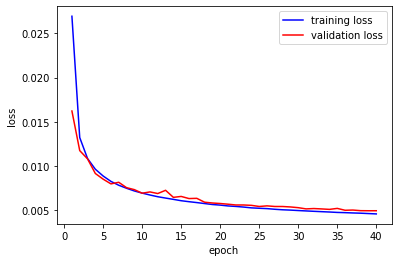

In [22]:
epoch_count = range(1, len(history.history['loss']) + 1)
plt.figure()
plt.plot(epoch_count, history.history['loss'], 'b', label = 'training loss')
plt.plot(epoch_count, history.history['val_loss'], 'r', label = 'validation loss')  
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Clearly, the network converges and the validation loss is almost equal to the training loss. The loss on held out test data is shown in the cell below.

In [23]:
test_loss = encoder_decoder.evaluate(X_test,X_test)
print('MSE Loss on test data: '+str(test_loss))

313/313 [==============================] - 15s 48ms/step - loss: 0.0050
MSE Loss on test data: 0.005017388146370649


<br>The cell below loads held out test data and displays several of the images in the set.

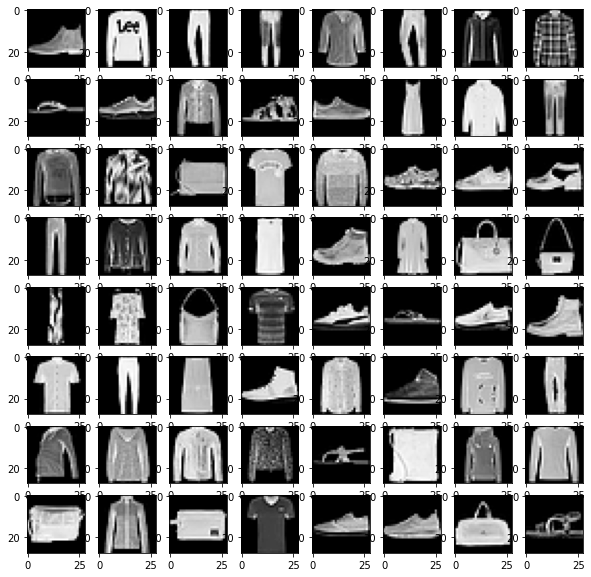

In [24]:
(X_tr_garb, y_tr_garb), (X_test, y_garb) = fashion_mnist.load_data()

fig, axes = plt.subplots(8,8,figsize = (10,10))
axes = axes.flatten()
for img, ax in zip(X_test[0:64],axes):
    ax.imshow(img,cmap='gray')
    
plt.show()

<br>Run the encoder-decoder on the held out set using ```predict```.

In [25]:
X_test_scaled = X_test.astype('float32')/255
X_test_scaled = X_test_scaled[:,:,:,np.newaxis]

rec_imgs = encoder_decoder.predict(X_test_scaled)

The cell below displays the outputs of the model. Clearly, the network learned to reconstruct the inputs, although the reconstructed images slightly lack the definition of the original images.

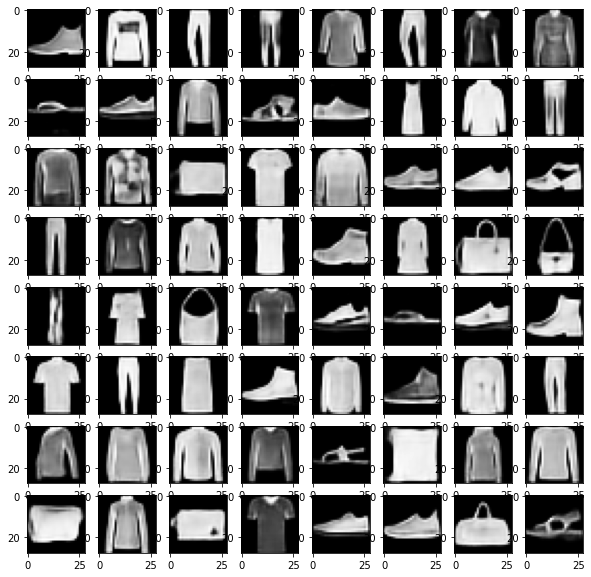

In [26]:
fig, axes = plt.subplots(8,8,figsize = (10,10))
axes = axes.flatten()
for img, ax in zip(rec_imgs[0:64],axes):
    #img_ = (img*255).astype('int8')
    ax.imshow(img,cmap='gray')
    
plt.show()

##### 2. Using the trained encoder for transfer learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist

import tensorflow as tf
import random

seed_value = 42
random.seed(seed_value)
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

from sklearn.model_selection import train_test_split

(X_train_val, y_train_val), (X_test, y_test) = fashion_mnist.load_data()
X_train_val, X_test = X_train_val.astype('float32')/255, X_test.astype('float32')/255
X_train_val = X_train_val[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=0.25)
y_train_1_hot = keras.utils.to_categorical(y_train, num_classes = 10)
y_val_1_hot = keras.utils.to_categorical(y_val, num_classes = 10)
y_test_1_hot = keras.utils.to_categorical(y_test, num_classes = 10)

In [2]:
enc_dec = keras.models.load_model("model_1\\encoder_decoder_39.hdf5")
enc_dec.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_15 (Sequential)   (None, 2, 2, 128)         98240     
_________________________________________________________________
sequential_16 (Sequential)   (None, 28, 28, 1)         430521    
Total params: 528,761
Trainable params: 528,761
Non-trainable params: 0
_________________________________________________________________


<br> The dense block below is instantiated. It is later appended to the trained encoder to get a classification network.

In [3]:
dense_block = keras.Sequential([
    layers.Flatten(input_shape=(2,2,128)),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(10,activation="softmax")
])

dense_block.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 70,122
Trainable params: 70,122
Non-trainable params: 0
____________________________________________________

<br>The cell below initializes the encoder, loads the learned weights and freezes its weights as described in [5].

In [4]:
fixed_block = keras.Sequential([
    layers.Conv2D(8, 3, activation="relu", input_shape = X_train[0].shape),
    layers.Conv2D(16, 3, activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, 3, activation="relu")
])

fixed_block.set_weights(enc_dec.layers[1].get_weights())
fixed_block.trainable = False

input_layer = keras.Input(shape=(28,28,1))

x = fixed_block(input_layer, training=False)
outputs = dense_block(x)

classifier = keras.Model(input_layer,outputs)

In [5]:
classifier.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

my_callbacks = [
keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True),
keras.callbacks.ModelCheckpoint(
        filepath="model_classification\\classifier_{epoch:02d}.hdf5", 
        monitor="val_loss", 
        save_best_only=True,
        verbose=1)
]

history = classifier.fit(x = X_train, 
                      y = y_train_1_hot, 
                      batch_size = 32,
                      epochs = 50,
                      validation_data = (X_val, y_val_1_hot),
                      callbacks=my_callbacks)

Epoch 1/50
1407/1407 [==============================] - ETA: 0s - loss: 0.6167 - accuracy: 0.7814
Epoch 00001: val_loss improved from inf to 0.38175, saving model to model_classification\classifier_01.hdf5
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6167 - accuracy: 0.7814 - val_loss: 0.3818 - val_accuracy: 0.8591
Epoch 2/50
1404/1407 [============================>.] - ETA: 0s - loss: 0.4351 - accuracy: 0.8426
Epoch 00002: val_loss improved from 0.38175 to 0.35217, saving model to model_classification\classifier_02.hdf5
1407/1407 [==============================] - 15s 11ms/step - loss: 0.4349 - accuracy: 0.8427 - val_loss: 0.3522 - val_accuracy: 0.8691
Epoch 3/50
1403/1407 [============================>.] - ETA: 0s - loss: 0.3956 - accuracy: 0.8578
Epoch 00003: val_loss improved from 0.35217 to 0.34143, saving model to model_classification\classifier_03.hdf5
1407/1407 [==============================] - 16s 11ms/step - loss: 0.3954 - accuracy: 0.8579 - val_loss:

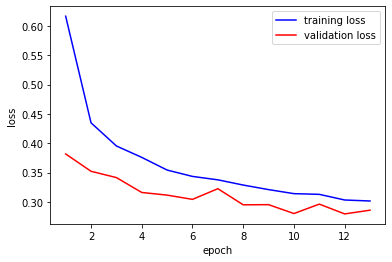

In [6]:
epoch_count = range(1, len(history.history['loss']) + 1)
plt.figure()
plt.plot(epoch_count, history.history['loss'], 'b', label = 'training loss')
plt.plot(epoch_count, history.history['val_loss'], 'r', label = 'validation loss')  
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

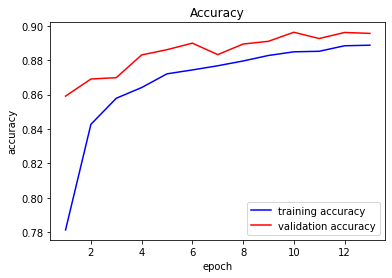

In [7]:
epoch_count = range(1, len(history.history['loss']) + 1)
plt.figure()
plt.plot(epoch_count, history.history['accuracy'], 'b', label = 'training accuracy')
plt.plot(epoch_count, history.history['val_accuracy'], 'r', label = 'validation accuracy') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Accuracy')
plt.show()

Test accuracy:

In [8]:
loss,accuracy = classifier.evaluate(X_test, y_test_1_hot)
print('Test accuarcy of the classifier model = ' + str(accuracy))

313/313 [==============================] - 3s 8ms/step - loss: 0.3075 - accuracy: 0.8903
Test accuarcy of the classifier model = 0.8902999758720398


Clearly, the learned encoder lacks the capacity to fully learn to classify the dataset. The results could easily be improved by increasing the size of the network. This experiment illustrates the utility of transfer learning.

##### 3. Using a decoder to generate new images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist

import tensorflow as tf
import random

seed_value = 42
random.seed(seed_value)
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

from sklearn.model_selection import train_test_split

(X_train_val, y_train_val), (X_test, y_test) = fashion_mnist.load_data()
X_train_val, X_test = X_train_val.astype('float32')/255, X_test.astype('float32')/255
X_train_val = X_train_val[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

In [2]:
enc_dec = keras.models.load_model("model_1\\encoder_decoder_39.hdf5")
enc_dec.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_15 (Sequential)   (None, 2, 2, 128)         98240     
_________________________________________________________________
sequential_16 (Sequential)   (None, 28, 28, 1)         430521    
Total params: 528,761
Trainable params: 528,761
Non-trainable params: 0
_________________________________________________________________


In [4]:
generator = keras.Sequential([
    layers.Conv2DTranspose(128, 3, activation="relu",input_shape = (2,2,128)),
    layers.Conv2D(128, 3, activation="relu",padding='same'),
    layers.UpSampling2D(size=(2, 2)),
    
    layers.Conv2DTranspose(64, 3, activation="relu"),
    layers.Conv2D(64, 3, activation="relu",padding='same'),
    layers.UpSampling2D(size=(2, 2)),
    
    layers.Conv2DTranspose(32, 3, activation="relu"),
    
    layers.Conv2DTranspose(16, 3, activation="relu"),
    
    layers.Conv2DTranspose(8, 3, activation="relu"),
    layers.Conv2D(4, 3, activation="relu",padding='same'),
    
    layers.Conv2DTranspose(2, 3, activation="relu"),
    layers.Conv2D(1, 3, activation="sigmoid",padding='same')
])

generator.set_weights(enc_dec.layers[2].get_weights())


encoder = keras.Sequential([
    layers.Conv2D(8, 3, activation="relu", input_shape = X_train_val[0].shape),
    layers.Conv2D(16, 3, activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, 3, activation="relu")
])

encoder.set_weights(enc_dec.layers[1].get_weights())

<br>In the cell below, we select two images from the held out test set from different image classes. In this case, the chosen classes are "t-shirt" and "pullover".

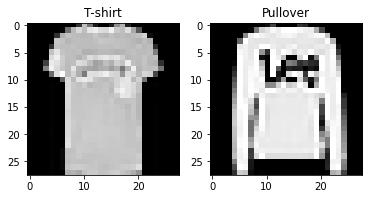

In [33]:
for x,y in zip(X_test,y_test):
    if y==0:
        t_shirt = x
        break

for x,y in zip(X_test,y_test):
    if y==2:
        pullover = x
        break
        
plt.figure()
plt.subplot(121)
plt.imshow(t_shirt,cmap='gray')
plt.title('T-shirt')
plt.subplot(122)
plt.imshow(pullover,cmap='gray')
plt.title('Pullover')
plt.show()

In [34]:
t_shirt = t_shirt[np.newaxis,:,:,:]
pullover = pullover[np.newaxis,:,:,:]

t_shirt.shape

(1, 28, 28, 1)

<br>Generate the code of the chosen images using the encoder:

In [35]:
t_shirt_code = encoder.predict(t_shirt)
pullover_code = encoder.predict(pullover)

print(t_shirt_code.shape)
print(pullover_code.shape)

(1, 2, 2, 128)
(1, 2, 2, 128)


<br> Linearly interpolate between the obtained codes and generate 4 intermediate codes.

In [36]:
weights = [0.2,0.4,0.6,0.8]
codes = np.zeros((4,2,2,128))

for i,w in enumerate(weights):
    codes[i] = t_shirt_code + w*(pullover_code-t_shirt_code)

In [37]:
codes = np.append(t_shirt_code,codes,axis=0)

In [28]:
codes.shape

(5, 2, 2, 128)

In [38]:
codes = np.append(codes,pullover_code,axis=0)

<br> Run the codes through the trained decoder network (named generator in this case). The generate images at the edges correspond to codes obtained from the actual data, while the images in between correspond to codes obtained via interpolation.

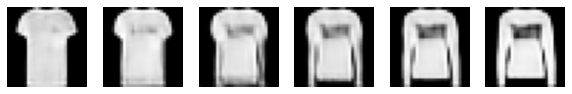

In [47]:
gen_imgs = generator(codes)

fig, axes = plt.subplots(1,6,figsize = (10,10))
axes = axes.flatten()
for img, ax in zip(gen_imgs,axes):
    ax.set_axis_off()
    ax.imshow(img,cmap='gray')
    
plt.show()

The generated images demonstrated the transformation between the outermost images. 

<br>Next, another example is demonstrated by selecting image from the same image class

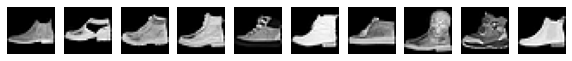

In [49]:
objects = []

for x,y in zip(X_test,y_test):
    if y==9:
        objects.append(x)
    if len(objects)==10:
        break
        
fig, axes = plt.subplots(1,10,figsize = (10,10))
axes = axes.flatten()
for img, ax in zip(objects,axes):
    ax.set_axis_off()
    ax.imshow(img,cmap='gray')

Two images are chosen by the user (hardcoded below) and the same interpolation is applied to generate new images. In this case the chosen images are the 1st (leftmost above) and the 9th.

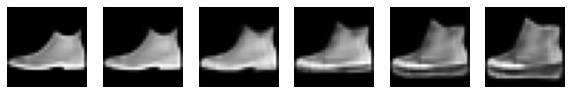

In [51]:
selected_obj = [objects[0],objects[8]]
obj_codes = []

for obj in selected_obj:
    obj_codes.append(encoder.predict(obj[np.newaxis,:,:,:]))

obj_codes = np.array(obj_codes)
interp_codes = np.zeros((4,2,2,128))
weights = [0.2,0.4,0.6,0.8]

for i,w in enumerate(weights):
    interp_codes[i] = obj_codes[0] + w*(obj_codes[1]-obj_codes[0])
    
interp_codes = np.append(obj_codes[0],interp_codes,axis=0)
interp_codes = np.append(interp_codes,obj_codes[1],axis=0)

gen_imgs_ = generator(interp_codes)

fig, axes = plt.subplots(1,6,figsize = (10,10))
axes = axes.flatten()
for img, ax in zip(gen_imgs_,axes):
    ax.set_axis_off()
    ax.imshow(img,cmap='gray')
    
plt.show()

Again, one can see the transformation between particular instances. It can be argued that the designs of the generated footwear are unique and no exact match exist in the training data.

Thus, one can see how encoder-decoder models learn the underlying distribution of the data and can be used to generate new samples. 

### Conclusion

This project introduced and discussed convolutional encoder-decoder networks. The trained network learns to reconstruct its input on the Fashion-MNIST dataset. Then, the trained encoder is applied to the task of transfer learning for image classification. The resulting classification performance 89% test accuracy is indicative of deficient capacity of the network, though the result is still respectable and illustrates the power of the encoder to produce good representation of the input. Next, the decoder is used to generate new image samples. This also is indicative of the ability of encoder-decoder network to capture the distribution of the data.

### References

[1] S. Minaee, Y. Y. Boykov, F. Porikli, A. J. Plaza, N. Kehtarnavaz and D. Terzopoulos, "Image Segmentation Using Deep Learning: A Survey," in *IEEE Transactions on Pattern Analysis and Machine Intelligence*, 2021.<br><br>
[2] X. Peng, R. S. Feris, X. Wang, and D. N. Metaxas, "A recurrent encoder-decoder network for sequential face alignment," in *European Conference on Computer Vision (ECCV)*, 2016.<br><br>
[3] I. Goodfellow, Y. Bengio, and A. Courville, Deep Learning, MIT Press, 2016.<br><br>
[4] V. Dumoulin, and V. Francesco, "A guide to convolution arithmetic for deep learning" arXiv e-print: 1603.07285, 2016.<br><br>
[5] F. Chollet. *Transfer learning and fine-tuning*, 2020. [Online] Available: https://keras.io/guides/transfer_learning/<br><br>
[6] H. Xiao, K. Rasul, and R. Vollgraf, "Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms." 2017. [Online]. Available: https://github.com/zalandoresearch/fashion-mnist<br><br>